# Calculate the microburst CDF and PDF
Author: Mykahylo Shumko

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
WRITE_CDF_TO_FILE = False

CATALOG_VERSION = 6
CAT_PATH = ('/home/mike/research/ac6_microburst_scale_sizes/data/'
            'coincident_microbursts_catalogues/'
            'AC6_coincident_microbursts_v{}.txt'.format(CATALOG_VERSION))

In [3]:
bins = np.arange(0, 200, 5)       # Separation bins
CC_THRESH = 0.8                   # Temporal CC threshold
CURTAIN_THRESH = 0.3              # Amount by which the temporal CC must be greater than the spatial CC.
PEAK_STD_THRESH = 3               # The number of standard deviations that a detection must be above a 10% 
                                  # Paul baseline.
WIDTH_THRESH = 0.1                # Width threshold in units of %/100.

## Load catalog

In [4]:
cat = pd.read_csv(CAT_PATH)

In [5]:
print(cat.shape); cat.head()

(87470, 20)


,dateTime,dos1rate,peak_std,Lm_OPQ,MLT_OPQ,lat,lon,alt,Dist_In_Track,Lag_In_Track,Dist_Total,Loss_Cone_Type,flag,AE,time_cc,space_cc,time_spatial_A,time_spatial_B,peak_width_A,peak_width_B
0,2014-06-28 15:25:12.199999,20.0001,1.414217,2.32720,22.9078,53.0947,116.772,634.221,105.277,13.9187,105.280,1.0,4.0,458.0,NaN,NaN,2014-06-28 15:24:58.281299,2014-06-28 15:25:12.199999,NaN,NaN
1,2014-06-28 15:25:13.900000,20.0001,1.414217,2.32222,22.9069,52.9924,116.727,634.104,105.278,13.9187,105.281,1.0,4.0,458.0,NaN,-0.090899,2014-06-28 15:24:59.981300,2014-06-28 15:25:13.900000,NaN,0.100000
2,2014-06-28 15:25:16,19.9981,1.414146,2.31060,22.9047,52.8662,116.665,633.991,105.279,13.9188,105.282,1.0,4.0,458.0,NaN,0.446300,2014-06-28 15:25:02.081200,2014-06-28 15:25:16,NaN,0.900021
3,2014-06-28 15:25:17.300000,10.0001,1.000005,2.29984,22.9027,52.7880,116.630,633.939,105.280,13.9188,105.283,1.0,4.0,458.0,NaN,0.522617,2014-06-28 15:25:03.381200,2014-06-28 15:25:17.300000,NaN,0.400000
4,2014-06-28 15:25:19,10.0001,1.000005,2.28859,22.9007,52.6857,116.582,633.892,105.281,13.9188,105.284,1.0,4.0,458.0,NaN,0.056534,2014-06-28 15:25:05.081200,2014-06-28 15:25:19,NaN,0.200000


As a reference, what is the number of valid spatial and temporal CCs?

In [6]:
cat[(~np.isnan(cat['time_cc'])) & (~np.isnan(cat['space_cc']))].shape[0]

81501

And now out of all of these detections, how many events had a temporal CC above CC_THRESH?

In [7]:
cat[cat['time_cc'] > CC_THRESH].shape[0]

3073

## Load sampling dataset
The number of AC-6 seconds taken between separations a and b is given by the exposure, $E(a, b)$. The exposure is calculated by finding all 10 Hz data that were taking simulatenorusly by units A and B. Furthermore the dos1rate data cannot be negative i.e. not -1E31 error values, and the data flag = 0.

In [8]:
EXPOSURE_PATH = '/home/mike/research/ac6_microburst_scale_sizes/data/norm/ac6_norm_all_cdf.csv'
E = pd.read_csv(EXPOSURE_PATH, index_col=0)

In [9]:
E.head()

,Seconds
Separation [km],
0,37141.3
5,33107.2
10,9474.2
15,14304.5
20,9199.1


## Find coincident events
I define events that are coincident by the following criteria:
 - High temporal CC
 - Temporal CC > Spatial CC + CURTAIN_THRESH
 - Events inside the radition belt i.e. 4 < L < 8.
 - Not above US or the SAA
 - Optional: at least 2 standard deviations above the 10% baseline. This does not seem to influince the CDF much, but with this on the CDF is smoother.

First filter by high temporal CC

In [10]:
coincidentEvents = cat[cat['time_cc'] >= CC_THRESH]

Filter by L (only radiation belt)

In [11]:
coincidentEvents = coincidentEvents[(np.abs(coincidentEvents['Lm_OPQ']) > 4) & 
                                    (np.abs(coincidentEvents['Lm_OPQ']) < 8)]

Filter out curtains

In [12]:
coincidentEvents = coincidentEvents[coincidentEvents['time_cc'] > coincidentEvents['space_cc']+CURTAIN_THRESH]

Filter out detections made above the US to completely get rid of potential ground transmitter noise

In [13]:
coincidentEvents = coincidentEvents[
                ((coincidentEvents['lon'] > -60) | (coincidentEvents['lon'] < -140)) |
                ((coincidentEvents['lat'] > 70) | (coincidentEvents['lat'] < 15))
                                ]

Filter out detections made above the SAA to get rid of any potential for noisy detections due to saturation

In [14]:
coincidentEvents = coincidentEvents[
                ((coincidentEvents['lon'] > 30)  | (coincidentEvents['lon'] < -116)) |
                ((coincidentEvents['lat'] < -90) | (coincidentEvents['lat'] > 0))
                                ]

Optional: filter events which were at least 2 standard deviations above the 10% baseline

In [15]:
if PEAK_STD_THRESH is not None:
    coincidentEvents = coincidentEvents[coincidentEvents['peak_std'] > PEAK_STD_THRESH]

Remove events with very different widths.

In [16]:
if WIDTH_THRESH is not None:
    coincidentEvents = coincidentEvents[np.isclose(coincidentEvents['peak_width_A'], 
                                               coincidentEvents['peak_width_B'], rtol=WIDTH_THRESH)]

### Sanity check: where were these detections made? 
This check makes sure that the US and SAA filters work correctly

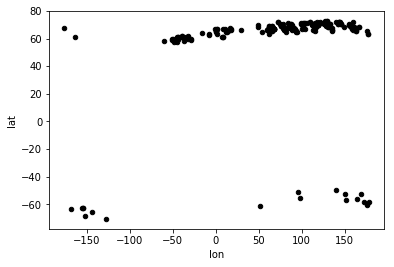

In [17]:
coincidentEvents.plot.scatter('lon', 'lat', c='k');

# Calculate the CDF Attempt 1
The microburst CDF at a separation $d$ is defined as the fraction of coincident microbursts observed at distance d to all the coincident microbursts in other words,

$$
CDF(d) = \frac{coincident > d}{all \ coincident}
$$

The intuitive way to think about this is with an example. When $d = 0$ km, the CDF = 1 i.e. 100% of microbursts were larger than $d$ and when $d = 25$ km the CDF = 0.4 i.e 40% of microbursts had a scale size larger than $d$.

First Calculate the total number of coincident microbursts

In [18]:
totalEvents = len(coincidentEvents); print(totalEvents)

238


Now iterate over each separation bin and calculate the CDF

In [19]:
cdf = np.array([(coincidentEvents['Dist_Total'] >= di).sum()/totalEvents for di in bins])
num = np.array([(coincidentEvents['Dist_Total'] >= di).sum() for di in bins])

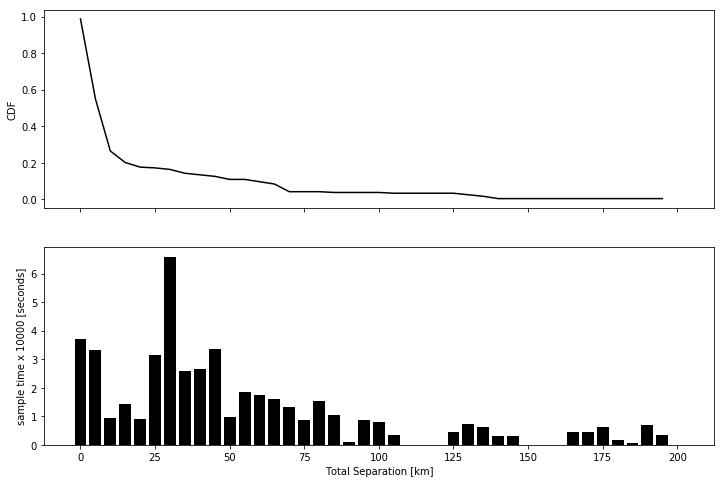

In [20]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 8))
ax[0].plot(bins, cdf, 'k'); ax[0].set_ylabel('CDF');
ax[1].bar(E.loc[0:200].index, E['Seconds'].loc[0:200]/10000, width=0.8*E.index[1]-E.index[0], color='k')
ax[1].set_ylabel('sample time x 10000 [seconds]'); ax[1].set_xlabel('Total Separation [km]');

## Calculate the PDF
by just taking the derivative of the CDF and constraining the area to 1.

In [21]:
pdf = np.convolve([-1, 1], cdf, mode='valid')/(E.index[1]-E.index[0])

In [22]:
print('Integral of the microburst PDF', round(sum(pdf), 2)*(E.index[1]-E.index[0]))

Integral of the microburst PDF 1.0


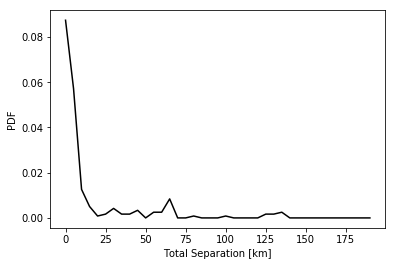

In [23]:
plt.plot(bins[:-1], pdf, 'k'); plt.xlabel('Total Separation [km]'); plt.ylabel('PDF');

In [24]:
if WRITE_CDF_TO_FILE:
    data = np.vstack((bins[:-1], cdf[:-1], pdf)).T
    pd.DataFrame(data=data).to_csv('microburst_cdf_pdf_v0.csv', 
                                   header=['Dist_Total', 'CDF', 'PDF'], index=False)

# Calculate the CDF Attempt 2
Here I attempt to account for the number of seconds that AC-6 took data togeather to remove a bias that comes from certain separations having more data than other separations. To take the exposure time into account, I reformulate the CDF in the following functional form

$$
CDF(d) = \frac{(coincident > d)/E(d, \inf)}{(all \ coincident)/E(0, \inf)} = \Big(\frac{(coincident > d)}{(all \ coincident)}\Big) \Big(\frac{E(0, \inf)}{E(d, \inf)}\Big)
$$

Visualize how the $E(0, \inf)/E(d, \inf)$ term looks like as a function of d

In [25]:
weights = [E.loc[0:500].sum()/E.loc[d:500].sum() for d in range(0, 201, 5)]

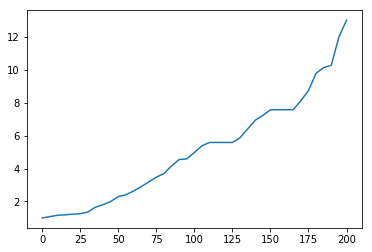

In [26]:
plt.plot(E.loc[0:200].index, weights);

In [27]:
cdf2 = np.array([(coincidentEvents['Dist_Total'] >= di).sum()/totalEvents*wi for di, wi in zip(bins, weights)])

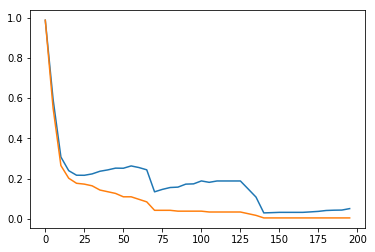

In [28]:
plt.plot(bins, cdf2); plt.plot(bins, cdf)

Need to check the detections above 100 km.